#  Get all required libraries

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor, ExtraTreesRegressor
import xgboost as xgb

# Shutdown warning prompts
import warnings
warnings.filterwarnings("ignore")
# to enable warnings: warnings.filterwarnings('always')

# Split data into train and test and print list of all columns and  list of columns containing NaN values

In [2]:
PATH = 'datasets'
def load_sales_data1(sales_path=PATH):
    csv_path = os.path.join(sales_path, "train.csv")
    return pd.read_csv(csv_path)


def load_sales_data2(sales_path=PATH):
    csv_path = os.path.join(sales_path, "test.csv")
    return pd.read_csv(csv_path)


train=load_sales_data1()
 
trainfull_df = train[train.columns.difference(['Product_Supermarket_Identifier'])]
testfull_df = load_sales_data2()

columns_list = testfull_df.columns.tolist()
columns_list = trainfull_df.columns.tolist()
print("Columns list: "+str(columns_list))

nan_columns = testfull_df.columns[pd.isnull(testfull_df).any()].tolist()
print("Columns containing NaN values: "+str(nan_columns))
#trainfull_df.info()

Columns list: ['Product_Fat_Content', 'Product_Identifier', 'Product_Price', 'Product_Shelf_Visibility', 'Product_Supermarket_Sales', 'Product_Type', 'Product_Weight', 'Supermarket _Size', 'Supermarket_Identifier', 'Supermarket_Location_Type', 'Supermarket_Opening_Year', 'Supermarket_Type']
Columns containing NaN values: ['Product_Weight', 'Supermarket _Size']


# Describe train dataset

In [3]:
print(trainfull_df.describe(include="all"))

       Product_Fat_Content Product_Identifier  Product_Price  \
count                 4990               4990    4990.000000   
unique                   3               1451            NaN   
top                Low Fat              NCL31            NaN   
freq                  3039                  9            NaN   
mean                   NaN                NaN     391.803796   
std                    NaN                NaN     119.378259   
min                    NaN                NaN      78.730000   
25%                    NaN                NaN     307.890000   
50%                    NaN                NaN     393.860000   
75%                    NaN                NaN     465.067500   
max                    NaN                NaN     667.220000   

        Product_Shelf_Visibility  Product_Supermarket_Sales Product_Type  \
count                4990.000000                4990.000000         4990   
unique                       NaN                        NaN           16   
top

# Describe test dataset

print(testfull_df.describe(include="all"))

# Performing data cleaning, some transformations(adding dummy variables and normalisation) to both train and test sets

In [4]:
def clean_and_normalise(df):
    # ===== list of Products and stores
    stores_train = np.sort(df['Supermarket_Identifier'].unique())
    Products_train = np.sort(df['Product_Identifier'].unique())
    #print(stores_train)
    # ===== remove all rows having all columns as NaN
    df = df.dropna(how='all')
    r,c = df.shape
    # replace nan on Product weight and Supermarket size
    df['Product_Weight'] = df['Product_Weight'].fillna(df['Product_Weight'].median())
    df['Supermarket _Size'] = df['Supermarket _Size'].fillna(df['Supermarket _Size'].mode()[0])

    # ===== Normalise Product_Fat_Content to lowercase and then to dummy variables
    df['Product_Fat_Content_Numeric'] = df['Product_Fat_Content'].map({"Ultra Low fat": 0, "Low Fat": 1, "Normal Fat": 2})

    # ===== Add dummy variable Supermarket_Size_Numeric column
    # print(df['Supermarket_Size'].unique())
    df['Supermarket_Size_Numeric'] = df['Supermarket _Size'].map({'Small' : 1, 'Medium' : 2, 'High' : 3})

    # ===== Add dummy variable Supermarket_Location_Type_Numeric column
    # print(df['Supermarket_Location_Type'].unique())
    df['Supermarket_Location_Type_Numeric'] = df['Supermarket_Location_Type'].map( {"Cluster 1": 1, "Cluster 2": 2, "Cluster 3": 3})

    # ===== Add dummy variable Supermarket_Type_Numeric column
    # print(df['Supermarket_Type'].unique())
    df['Supermarket_Type_Numeric'] = df['Supermarket_Type'].map(
        {'Supermarket Type1' : 1, 'Supermarket Type2' : 2, 'Supermarket Type3' : 3, 'Grocery Store' : 4})

    # ===== Add dummy variable Product_Type_Numeric column
    Product_type_list = list(trainfull_df['Product_Type'].unique())
    # print(Product_type_list)
    df['Product_Type_Numeric'] = [0]*r #initialise column with zeros to specify integers

    for i in range(r):
        Producttype = str(df['Product_Type'].loc[i])
        df['Product_Type_Numeric'].set_value(i, Product_type_list.index(Producttype))
    
    # ===== Normalise Supermarket_Opening_Year
    est_year_list = list(df['Supermarket_Opening_Year'].unique())
    # print(est_year_list)
    df['Age'] = [0]*r      #initialise column with zeros to specify integers

    for i in range(r):
        curryear = df['Supermarket_Opening_Year'].loc[i]
        df['Age'].set_value(i, (2013-curryear))
    
    # ==== Adding new dummy variable PRICE_Low_High column
    Price_low_high = []
    for i in range(df.shape[0]):
        curr_Price = df['Product_Price'].loc[i]
        if(curr_Price <= 69):
            Price_low_high.append(0)
        elif(curr_Price <= 136):
            Price_low_high.append(1)
        elif(curr_Price <= 203):
            Price_low_high.append(2)
        else:
            Price_low_high.append(3)
    df['PRICE_Low_High'] = Price_low_high
    
    # ==== Adding new dummy variable Product_Shelf_Visibility_New column
    max_visi = df['Product_Shelf_Visibility'].max()
    min_visi = df['Product_Shelf_Visibility'].min()
    qrt_visi = (max_visi + min_visi)/4
    visi_low_high = []
    for i in range(df.shape[0]):
        curr_value = df['Product_Shelf_Visibility'].loc[i]
        if(curr_value <= qrt_visi):
            visi_low_high.append(0)
        elif(curr_value <= (qrt_visi*2)):
            visi_low_high.append(1)
        elif(curr_value <= (qrt_visi*3)):
            visi_low_high.append(2)
        else:
            visi_low_high.append(3)
    df['Product_Shelf_Visibility_New'] = visi_low_high
    
    # ==== Supermarket_Location_Type and Product_Fat_Content combined column
    loctype = ['Cluster 1', 'Low Fat', 'Cluster 2', 'Cluster 3', ]
    Productfat = ['Ultra Low fat', 'Low Fat', 'Normal Fat']
    loctype_Productfat=[['Cluster 1', 'Ultra Low fat'], ['Cluster 1', 'Low Fat'], ['Cluster 1', 'Normal Fat']
                     , ['Cluster 2', 'Ultra Low fat'], ['Cluster 2', 'Low Fat'], ['Cluster 2', 'Normal Fat']
                     , ['Cluster 3', 'Ultra Low fat'], ['Cluster 3', 'Low Fat'], ['Cluster 3', 'Normal Fat']]
    df['Loctype_Productfat'] = [0]*r
    for i in range(r):
        currlocctype = df['Supermarket_Location_Type'].loc[i]
        currProductfat = df['Product_Fat_Content'].loc[i]
        df['Loctype_Productfat'].set_value(i, loctype_Productfat.index([currlocctype, currProductfat]))
    
    return df



trainfull_df = clean_and_normalise(trainfull_df)
testfull_df = clean_and_normalise(testfull_df)


# Data types of each column

print(" ===== TRAIN =====\n"+str(trainfull_df.dtypes))
print("\n ===== TEST =====\n"+str(testfull_df.dtypes))


# Plotting some graphs
## *Outlet_Size* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

plt.figure(figsize=(10,7))
sns.boxplot(x='Supermarket _Size', y='Product_Supermarket_Sales', data = trainfull_df, hue="Product_Fat_Content")

## *Outlet_Location_Type* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

plt.figure(figsize=(10,7))
sns.boxplot(x='Supermarket_Location_Type', y='Product_Supermarket_Sales', data = trainfull_df, hue="Product_Fat_Content")

## *Outlet_Type* vs *Item_Outlet_Sales* color divided on *Item_Fat_Content*

plt.figure(figsize=(10,7))
sns.boxplot(x='Supermarket_Type', y='Product_Supermarket_Sales', data = trainfull_df, hue="Product_Fat_Content")

## Correlation Heatmap

corr_matrix = trainfull_df.corr()
f, ax = plt.subplots(figsize=(20, 12))
sns.heatmap(corr_matrix, linewidths=2.0, ax=ax, annot=True)
ax.set_title('Correlation Matrix')

In [5]:
features2 = ['Supermarket_Type_Numeric', 'Product_Price', 'Supermarket_Size_Numeric', 'Supermarket_Location_Type_Numeric', 'PRICE_Low_High'
      'Product_Shelf_Visibility', 'Product_Weight',#'Product_Fat_Content_Numeric', 
             'Age',  'Product_Shelf_Visibility_New'      ]
#'Loctype_Productfat','Product_Type_Numeric',

features = ['Product_Price','Supermarket_Type_Numeric', 'Supermarket_Location_Type_Numeric', 'Age', 
            #'Loctype_Productfat'
      'Supermarket_Size_Numeric', 'Product_Shelf_Visibility', 'PRICE_Low_High'
    , #'Product_Fat_Content_Numeric', 'Product_Type_Numeric', 
            'Product_Shelf_Visibility_New', 'Product_Weight'  ]

## Plotting feature importance graph using XGB's *plot_importance*

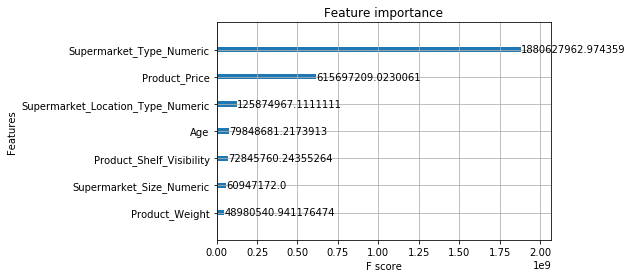

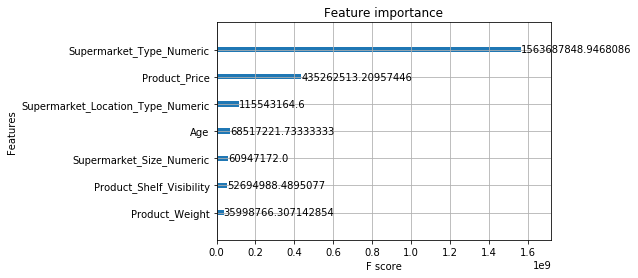

In [6]:
train = trainfull_df[:int(trainfull_df.shape[0]*0.8)]
# print(train)
test = trainfull_df[int(trainfull_df.shape[0]*0.8):]
# print(test)

estimators = [50, 75]
for e in estimators:
    xg = xgb.XGBRegressor(n_estimators = e)
    
#     plt.figure(figsize=(10,10))
    xg.fit(train[features], train['Product_Supermarket_Sales'])
    xgb.plot_importance(xg, importance_type='gain')#, ax=ax1)


# Determining which of *RandomForestRegressor* or *GradientBoostingRegressor* or *XGBRegressor* will have minimum RMSE Error

In [7]:
def prediction_function(train, test):
    estimators = [50, 75, 80, 100, 125, 150, 200, 250, 500]

    final = []

    for e in estimators:
        rf = RandomForestRegressor(random_state = 1, n_estimators = e, min_samples_split = 8, min_samples_leaf = 4)
        gbr = GradientBoostingRegressor(random_state = 1, n_estimators = e, min_samples_split = 8, 
                                        min_samples_leaf = 4, learning_rate = 0.1)
        xg = xgb.XGBRegressor(n_estimators = e)

        rf.fit(train[features], train['Product_Supermarket_Sales'])
        predictions_rf = rf.predict(test[features])
        predictions_rf = predictions_rf.astype(int)

        gbr.fit(train[features], train['Product_Supermarket_Sales'])
        predictions_gbr = gbr.predict(test[features])
        predictions_gbr = predictions_gbr.astype(int)

        xg.fit(train[features], train['Product_Supermarket_Sales'])
        predictions_xg = xg.predict(test[features])
        predictions_xg = predictions_xg.astype(int)

        mse_rf = (np.sqrt(mean_squared_error(test['Product_Supermarket_Sales'], predictions_rf)), 'RF')
        mse_gbr = (np.sqrt(mean_squared_error(test['Product_Supermarket_Sales'], predictions_gbr)), 'GBR')
        mse_xg = (np.sqrt(mean_squared_error(test['Product_Supermarket_Sales'], predictions_xg)), 'XGB')

        error_min = min(mse_rf, min(mse_gbr, mse_xg))
#         print(error_min)
        final.append((error_min, e))

    min_final = min(final)
    print("Minimum MSE, regressor to use and number of estimators: "+str(min_final))
    return list(min_final)

In [8]:
train = trainfull_df[:int(trainfull_df.shape[0]*0.8)]
test = trainfull_df[int(trainfull_df.shape[0]*0.8):]
min_final = prediction_function(train, test)

Minimum MSE, regressor to use and number of estimators: ((2721.1462706973066, 'GBR'), 80)


In [9]:
e_to_use = min_final[1]
regressor_to_use = min_final[0][1]
# print("Mimimum RMSE error was for "+str(regressor_to_use)+" with "+str(e_to_use)+" estimators")

if(regressor_to_use == 'RF'):
    reg = RandomForestRegressor(random_state = 1, n_estimators = e_to_use, min_samples_split = 8, min_samples_leaf = 4)
elif(regressor_to_use == 'GBR'):
    reg = GradientBoostingRegressor(random_state = 1, n_estimators = e_to_use, min_samples_split = 8, min_samples_leaf = 4, learning_rate = 0.1)
else:
    reg = xgb.XGBRegressor(n_estimators = e_to_use)

reg.fit(trainfull_df[features], trainfull_df['Product_Supermarket_Sales'])
predictions = reg.predict(testfull_df[features])
predictions = predictions.astype(int)

# Writing final output to csv file *output.csv*

In [10]:
h = pd.DataFrame()
h['Product_Supermarket_Identifier'] = testfull_df['Product_Supermarket_Identifier']
h['Product_Supermarket_Sales'] = pd.DataFrame(predictions)
print(h)
#sub = pd.DataFrame( {'Product_Identifier' : train['Product_Identifier'], 'Product_Supermarket_Sales' : testfull_df['Product_Supermarket_Sales'], 'Product_Supermarket_Sales' : predictions})
h.to_csv('output/result.csv', index=False)

     Product_Supermarket_Identifier  Product_Supermarket_Sales
0                 DRA59_CHUKWUDI010                       1272
1                 DRA59_CHUKWUDI013                       8301
2                 DRB01_CHUKWUDI013                       8278
3                 DRB13_CHUKWUDI010                        946
4                 DRB13_CHUKWUDI013                       7810
5                 DRB25_CHUKWUDI017                       4537
6                 DRB25_CHUKWUDI027                       6847
7                 DRB25_CHUKWUDI035                       4537
8                 DRB48_CHUKWUDI017                       2712
9                 DRB48_CHUKWUDI027                       5123
10                DRB48_CHUKWUDI035                       2758
11                DRB48_CHUKWUDI046                       2656
12                DRB48_CHUKWUDI049                       2573
13                DRC01_CHUKWUDI017                       2472
14                DRC01_CHUKWUDI018                    